In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt

In [2]:
def plot_result(result,start_from=1,period=20,insert_index=4,time_start=-5,file_name="result",title="Event Study Coefficients with Confidence Intervals"):
    summary_table=pd.DataFrame(result.summary.tables[1].data[start_from:start_from+period],columns=result.summary.tables[1].data[0])
    new_row=[0]*len(summary_table.columns)
    # insert_index = 4
    summary_table = pd.concat([summary_table.iloc[:insert_index], pd.DataFrame([new_row],columns=summary_table.columns), summary_table.iloc[insert_index:]]).reset_index(drop=True)

    summary_table["Time"]=np.array(list(range(time_start,period+time_start+1)))
    # make each column of summary_table numeric
    summary_table=summary_table.apply(pd.to_numeric, errors='ignore')
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed

    # Plot coefficients as points
    plt.plot(summary_table['Time'], summary_table["Parameter"], 'o-', label='Coefficients', color='b')

    # Plot confidence intervals as error bars
    # plt.errorbar(summary_table['Time'], summary_table["Parameter"],
    #              yerr=[summary_table["Parameter"] - summary_table['Lower CI'],
    #                    summary_table['Upper CI'] - summary_table["Parameter"]],
    #              fmt='none', ecolor='orange', elinewidth=2, capsize=4, label='Confidence Intervals')

    plt.fill_between(summary_table['Time'], summary_table['Lower CI'], summary_table['Upper CI'], color='orange', alpha=0.3, label='Confidence Intervals')

    plt.xlabel('Time')
    # Set y-axis properties
    plt.ylim(-1, 1)  # Set the y-axis limits
    plt.ylabel("Parameter")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig("./plots/{}.png".format(file_name),dpi=300,bbox_inches="tight",transparent=False,facecolor="white")
    plt.show()
    # return summary_table

In [3]:
df=pd.read_csv("../../data/merged/len3_ship_agg_drop_never.csv",encoding="shift-jis",index_col=0)
# sum ver.
# df=pd.read_csv("../data/merged/len3_ship_sum_agg_drop_never.csv",encoding="shift-jis",index_col=0)

Estimation

In [4]:
## processing
df_columns = df.columns # 列名をリストとして取得
import re

# 正規表現パターンを作成します
pattern = r'id|^elasped_(m[0-5]|[0-9]|1\d|20)$'

# 列名のリストを作成します
column_names = [col for col in df_columns if re.search(pattern, col)]

# 列名のリストを表示します
print(column_names)
rest_columns=["year","generic_per"]
column_names=rest_columns+column_names
# try:
#     column_names.remove("elasped_m1")
# except:
#     1

try:
    column_names.remove("elasped")
except:
    1
try:
    column_names.remove("id")
except:
    1
try:
    column_names.remove("id_114")
except:
    1
# column_names

['id', 'elasped_m5', 'elasped_m4', 'elasped_m3', 'elasped_m2', 'elasped_m1', 'elasped_0', 'elasped_1', 'elasped_2', 'elasped_3', 'elasped_4', 'elasped_5', 'elasped_6', 'elasped_7', 'elasped_8', 'elasped_9', 'elasped_10', 'elasped_11', 'elasped_12', 'elasped_13', 'elasped_14', 'elasped_15', 'elasped_16', 'elasped_17', 'elasped_18', 'elasped_19', 'elasped_20', 'id_114', 'id_121', 'id_123', 'id_124', 'id_131', 'id_132', 'id_211', 'id_218', 'id_222', 'id_223', 'id_224', 'id_225', 'id_229', 'id_231', 'id_232', 'id_235', 'id_239', 'id_245', 'id_252', 'id_259', 'id_264', 'id_265', 'id_313', 'id_321', 'id_332', 'id_339', 'id_391', 'id_399', 'id_441', 'id_449', 'id_625', 'id_629', 'id_799']


In [5]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_dom"]>0]
df=df.loc[df["rx_dom"]>0]

# make log columns
df["log_rx_dom"]=np.log(df["rx_dom"])
df["log_otc_dom"]=np.log(df["otc_dom"])
df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"]+0.001)
df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"]+0.001)
df["year_trend"]=df["year"]-2008

In [6]:
df=df.set_index(["id","year"])
df.info()
# make this to paneldata
df=PanelData(df)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 372 entries, (114, 2008) to (799, 2021)
Columns: 111 entries, efficacy to year_trend
dtypes: float64(17), int64(90), object(4)
memory usage: 325.3+ KB


(182, 14, 29)

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

## RX

In [7]:
# formula="rx_dom ~ year_trend+elasped_m10+elasped_m9+elasped_m8+elasped_m7+elasped_m6+elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"
# # stock lag version
# # formula+="+stock_rx_lag"
# # gemeric_per
# formula+=" + generic_per"
# mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
# res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# # print(res_fe.summary.tables[1])
# # print(res_fe.summary.tables[0])
# print(res_fe)
# plot_result(res_fe,file_name="rx",title="rx",period=25,insert_index=9,time_start=-10)
# # print(x)

In [8]:
[0]*5

[0, 0, 0, 0, 0]

                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
elasped_m10         -0.1377     0.1153    -1.1942     0.2334     -0.3648      0.0893
elasped_m9          -0.0913     0.1260    -0.7250     0.4690     -0.3393      0.1566
elasped_m8          -0.0012     0.0655    -0.0185     0.9852     -0.1302      0.1278
elasped_m7          -0.0256     0.0723    -0.3545     0.7232     -0.1679      0.1166
elasped_m6           0.0356     0.0655     0.5434     0.5873     -0.0934      0.1646
elasped_m5           0.0896     0.0652     1.3740     0.1706     -0.0388      0.2179
elasped_m4          -0.0329     0.0577    -0.5705     0.5688     -0.1464      0.0806
elasped_m3           0.0240     0.0272     0.8824     0.3783     -0.0295      0.0775
elasped_m2           0.0439     0.0501     0.8770     0.3813     

c:\Users\hakos\AppData\Local\Programs\Python\Python310\lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\hakos\AppData\Local\Temp\ipykernel_16192\1100424910.py:16: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

year_trend, generic_per

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


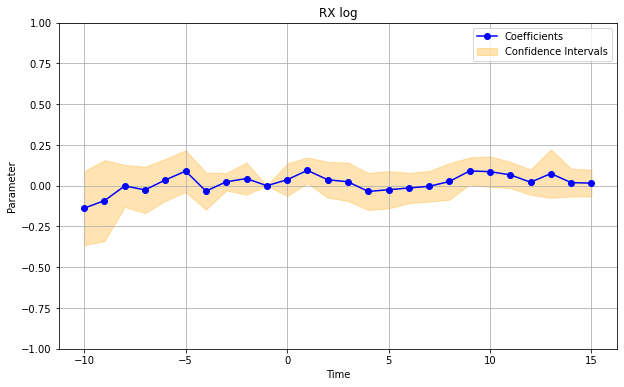

In [9]:
# take log
formula="log_rx_dom ~ year_trend+elasped_m10+elasped_m9+elasped_m8+elasped_m7+elasped_m6+elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+TimeEffects+EntityEffects"
# stock lag version
formula+="+log_stock_rx_lag"

# generic_per
formula+=" + generic_per"

# generic_share_r
formula+=" + generic_share_r"

# generic_share_q
formula+=" + generic_share_q"

mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="rx_log",title="RX log",period=25,insert_index=9,time_start=-10)

### OTC

In [10]:

# formula="otc_dom ~ year_trend+elasped_m10+elasped_m9+elasped_m8+elasped_m7+elasped_m6+elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"
# # stock lag version
# # formula+="+stock_otc_lag"
# # gemeric_per
# formula+=" + generic_per"
# mod_fe=PanelOLS.from_formula(formula, data=df, drop_absorbed=True)
# # mod_fe=PanelOLS.from_formula(formula, data=df, drop_absorbed=False)
# res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# print(res_fe.summary.tables[1])
# print(res_fe.summary.tables[0])
# plot_result(res_fe,file_name="otc",title="OTC",period=25,insert_index=9,time_start=-10)

c:\Users\hakos\AppData\Local\Programs\Python\Python310\lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\hakos\AppData\Local\Temp\ipykernel_16192\3646895726.py:22: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

generic_per

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:            log_otc_dom   R-squared:                        0.2835
Estimator:                   PanelOLS   R-squared (Between):              0.0900
No. Observations:                 346   R-squared (Within):               0.2705
Date:                Wed, Sep 06 2023   R-squared (Overall):              0.0914
Time:                        20:56:21   Log-likelihood                   -184.73
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3.9139
Entities:                          29   P-value                           0.0000
Avg Obs:                       11.931   Distribution:                  F(28,277)
Min Obs:                       1.0000                                           
Max Obs:                       13.000   F-statistic (robust):          2.313e+13
                            

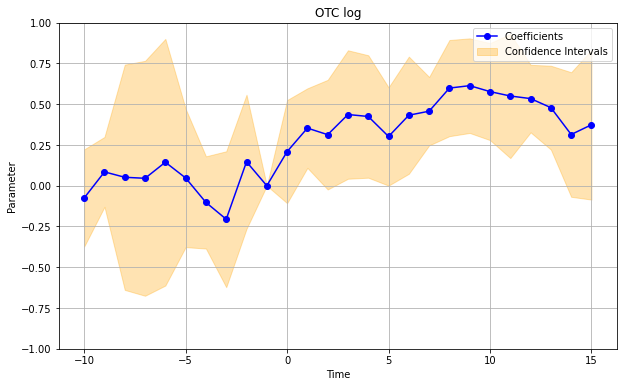

In [11]:
# take log
formula="log_otc_dom ~elasped_m10+elasped_m9+elasped_m8+elasped_m7+elasped_m6+ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"

# till 15
formula="log_otc_dom ~elasped_m10+elasped_m9+elasped_m8+elasped_m7+elasped_m6+elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+TimeEffects+EntityEffects"

# stock lag version
formula+="+log_stock_otc_lag"

# year trend
# formula+="+year_trend"

# gemeric_per
formula+=" + generic_per"

# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"

mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
# print(res_fe.summary.tables[1])
# print(res_fe.summary.tables[0])
print(res_fe)
plot_result(res_fe,file_name="otc_log",title="OTC log",period=25,insert_index=9,time_start=-10)